# Analysis of differential cell abundance in time - Myeloid cells

In this notebook we test for differential abundance in immune cell populations using [Milo](https://www.biorxiv.org/content/10.1101/2020.11.23.393769v1) (python implementation [milopy](https://github.com/emdann/milopy))

In [1]:
%load_ext autoreload
%autoreload 2

In [96]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

import milopy.core as milo
import milopy.plot as milopl

In [3]:
## import project utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

In [4]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/milo_analysis_MYELOID/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
import milopy

def annotate_nhoods(adata, anno_col):
    anno_dummies = pd.get_dummies(adata.obs[anno_col])
    anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
    anno_frac = np.array(anno_count/anno_count.sum(1))

    anno_frac = pd.DataFrame(anno_frac, 
                             columns=anno_dummies.columns,
                             index=adata.uns["nhood_adata"].obs_names
                            )
    adata.uns["nhood_adata"].obsm["frac_annotation"] = anno_frac.values
    adata.uns["nhood_adata"].uns["annotation_labels"] = anno_frac.columns
    adata.uns["nhood_adata"].obs["nhood_annotation"] = anno_frac.idxmax(1)
    adata.uns["nhood_adata"].obs["nhood_annotation_frac"] = anno_frac.max(1)

## Load data

In [9]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="MYELOID"

In [10]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split))
adata.var_names_make_unique()

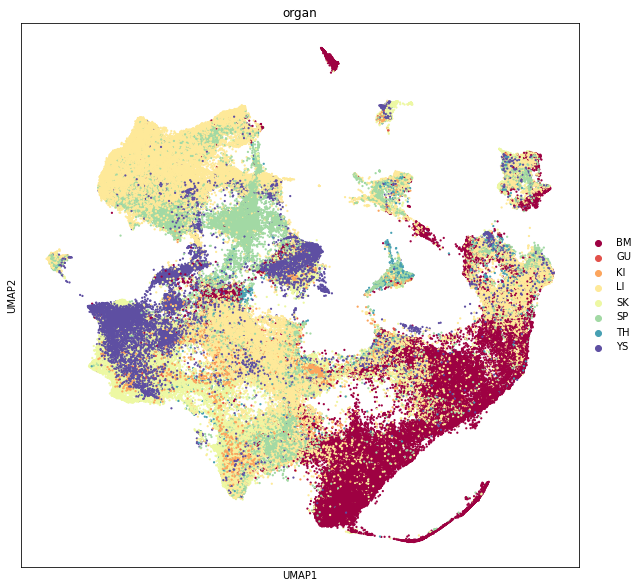

In [54]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color="organ", palette="Spectral", size=20)

In [21]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])

adata = adata[~adata.obs_names.isin(mat_barcodes["x"])]

### Load annotations

In [28]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
adata = adata[adata.obs_names.isin(anno_obs.index)].copy()
adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[adata.obs_names]["anno_lvl_2_final_clean"]

## Accounting for bias in FACS sorting
Load CD45+/- proportions, provided by Isaac

In [29]:
facs_prop_df = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/meta_share/220621_FACs_gating_proportions_correct.csv")

## Keep only CD45+ and CD45- cells
facs_prop_df = facs_prop_df[facs_prop_df["sort.ids"].isin(["CD45+", "CD45-"])]

## Distinguish tissues where there have been multiple sorts by the no of total events 
facs_prop_df["sort_sample_id"] = facs_prop_df.origin + "_" + facs_prop_df["orig.ident"] + "_" + facs_prop_df.total_live_events.astype("str")

## Add to obs and visualize on UMAP
obs_names = adata.obs.index.copy()
new_obs = pd.merge(adata.obs, facs_prop_df, how="left", indicator=True)
new_obs.index = obs_names

adata.obs = new_obs.drop("_merge", 1).copy()

... storing 'Sample.lanes' as categorical
... storing 'anno_lvl_2_final_clean' as categorical
... storing 'orig.ident' as categorical
... storing 'sort.ids' as categorical
... storing 'origin' as categorical
... storing 'count' as categorical
... storing 'total_live_events' as categorical
... storing 'sort_sample_id' as categorical


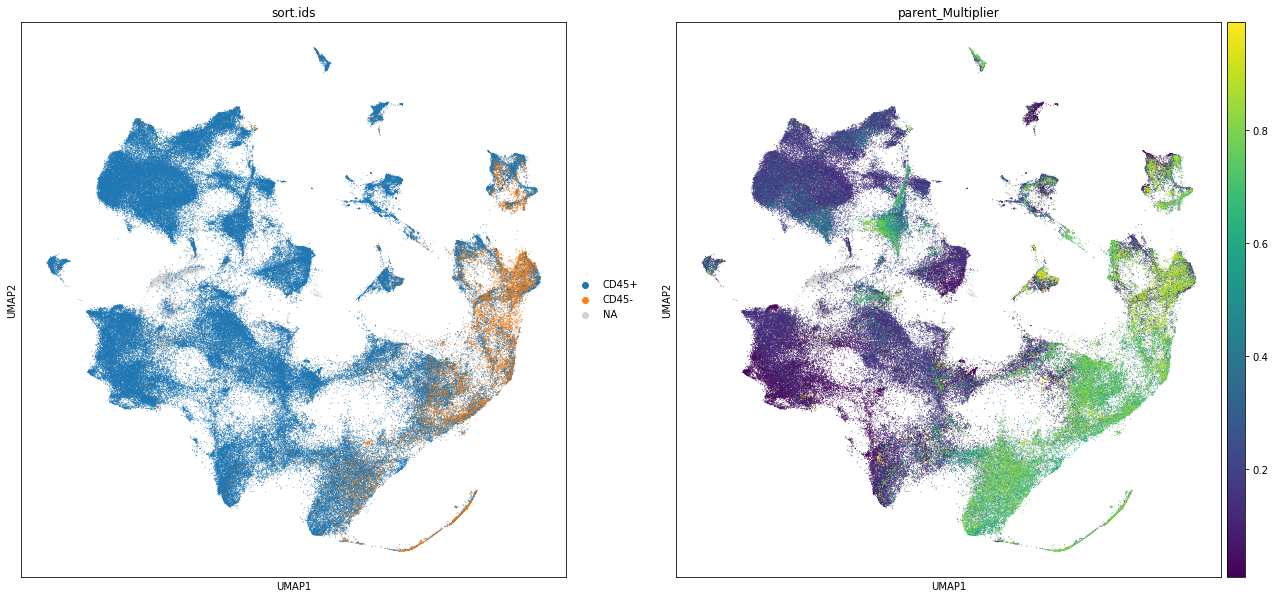

In [30]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=["sort.ids","parent_Multiplier"], size=3)

### Pre-processing for differential abundance testing

We bin gestational ages in 6 windows of 2 weeks length.

In [31]:
cut_labels_4 = ['< 8pcw', '< 10pcw', '< 12pcw', '< 14pcw', '< 16pcw', '< 18pcw']
cut_bins = [0, 8, 10, 12, 14, 16, 18]
adata.obs["age_bins"] = pd.cut(adata.obs["age"], bins=cut_bins, labels=cut_labels_4).astype("str")
adata.obs["age_bins"] = pd.Categorical(adata.obs["age_bins"], categories=cut_labels_4, ordered=True)
adata.obs["age_bins"]

## Convert covariate to continous
adata.obs['age_bins'] = adata.obs['age_bins'].cat.codes

We keep cells sorted for CD45+, CD45- or total.

In [32]:
### Fix sort ids
adata.obs["Sort_id"] = ["CD45P" if x == "CD45P_CD45N" else x for x in adata.obs["Sort_id"]]
adata.obs["Sort_id"] = ["CD45N" if x == "CD45EN" else x for x in adata.obs["Sort_id"]]

### Exclude cells from unconventional sorts
adata = adata[adata.obs["Sort_id"].isin(["CD45P", "CD45N", "TOT"])]
### Exclude CD45P/N cells that don't have true fraction quantification
# (mainly Gut, ask Rasa)
adata = adata[~(adata.obs["Sort_id"].isin(["CD45P", "CD45N"]) & adata.obs["sort.ids"].isna())]

In [33]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")

In [34]:
## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="Sample.lanes")

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Calculate correction factor for each sample

We define the correction factor as 

$$ f_{n} = \log \frac{p_n \cdot \sum_n{S_n}}{S_n} $$

where $p_n$ represents the true proportion of cells from sort $n$ in the tissue samples (column `parent_Multiplier` in FACS table), and $S_n$ represents the total number of cells in sort $n$ (of note, this doesn't coincide with the sum of all $c_{n,i}$ since the same cell can be included in multiple neighbourhoods).

For the unsorted samples we set the correction factor to 0.

In [35]:
import milopy
def _add_FACS_correction_factor(adata):
    milopy.utils.add_covariate_to_nhoods_var(adata,["parent_Multiplier", "sort.ids", 'donor', 'sort_sample_id'])
    nhood_adata = adata.uns["nhood_adata"].copy()
    ## Keep only samples with CD45+/CD45- ratio information
    nhood_adata = nhood_adata[:,nhood_adata.var["sort.ids"].isin(["CD45+", "CD45-"])]
    ## Exclude neighbourhoods that are empty after filtering
    nhood_adata = nhood_adata[nhood_adata.X.sum(1) > 0]
    ## Apply correction
    X_counts = nhood_adata.X.toarray()
    adata.obs["n_sort"] = adata.obs["sort_sample_id"].astype("str") + "_" + adata.obs["sort.ids"].astype("str")
    nhood_adata.var["n_sort"] = nhood_adata.var["sort_sample_id"].astype("str") + "_" + nhood_adata.var["sort.ids"].astype("str")
    sum_i_c_n = adata.obs["n_sort"].value_counts()[nhood_adata.var["n_sort"]].values
    p = nhood_adata.var["parent_Multiplier"].astype("float").values
    sum_S = adata.obs["sort_sample_id"].value_counts()[nhood_adata.var["sort_sample_id"]].values
    count_correction_fact = (p * sum_S)/sum_i_c_n
    fact_correction_df = pd.DataFrame([count_correction_fact, nhood_adata.var_names]).T
    
    fact_correction_df.columns = ["correction_factor", "Sample.lanes"]
    new_obs = pd.merge(adata.obs, fact_correction_df,how="left")
    new_obs.index = adata.obs_names
    adata.obs = new_obs.copy()
    adata.obs["correction_factor"]= adata.obs["correction_factor"].astype("float64")
    adata.obs["correction_factor"] = np.log10(adata.obs["correction_factor"])
    return(adata, count_correction_fact)

In [36]:
## Add correction factor
if "correction_factor" in adata.obs.columns:
    adata.obs = adata.obs.drop("correction_factor",1)
    del adata.uns["nhood_adata"].var["correction_factor"]
adata,fact = _add_FACS_correction_factor(adata)
## Set factor to 0 for unsorted samples
adata.obs.loc[adata.obs["Sort_id"]=="TOT","correction_factor"] = 0

Trying to set attribute `.var` of view, copying.


In [37]:
import milopy.core as milo
def _milo_test_by_organ(adata, design="~ Sort_id + age_bins", sample_col="Sample.lanes", test_organs = None):  
    if test_organs is None:
        ## Keep organs covering at least two time-points
        df = adata.obs[["organ",sample_col, "age_bins"]].drop_duplicates()
        df = df.groupby(["organ","age_bins"]).count().reset_index().pivot("organ",columns="age_bins")
        sampled_organs = df.index[(df > 0).sum(1) > 2]
    else:
        sampled_organs = test_organs

    ## Calculate logFC and SpatialFDR within each organ
    milo_res_dict = {}
    for org in sampled_organs:
        print(org)
        org_samples = adata.obs[adata.obs["organ"] == org][sample_col].unique()
        milo.DA_nhoods(adata, design=design, subset_samples=org_samples)
        milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

    ## Collapse results
    logFC_df_ls = [v["logFC"] for k,v in milo_res_dict.items()]
    for k,v in milo_res_dict.items():
        milo_res_dict[k]["logFC_" + k] = milo_res_dict[k]["logFC"].copy()
        milo_res_dict[k]["SpatialFDR_" + k] = milo_res_dict[k]["SpatialFDR"].copy()

    org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
    org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)
    return(milo_res_dict, org_fc, org_fdr)

In [38]:
milo_res_2, org_fc_2, org_fdr_2 = _milo_test_by_organ(adata, 
                                                      design="~ correction_factor + age_bins",
                                                      test_organs = ["BM", "LI", "SK", "SP", "TH"]
                                                     )

BM


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


LI
SK
SP
TH


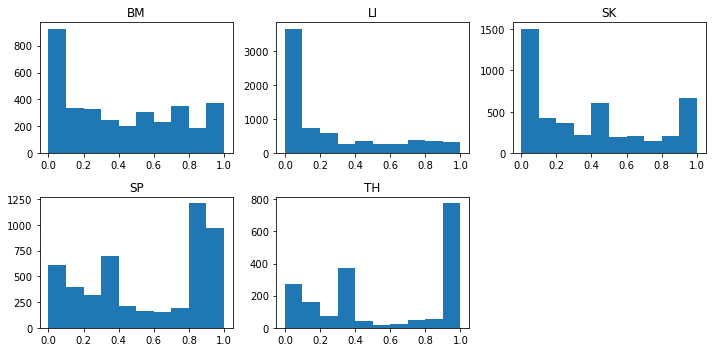

In [39]:
plt.rcParams["figure.figsize"] = [10,5]
i=1
for k in milo_res_2.keys():
    plt.subplot(2,3,i)
    plt.hist(milo_res_2[k].PValue);
    plt.title(k);
    plt.tight_layout();
    i+=1

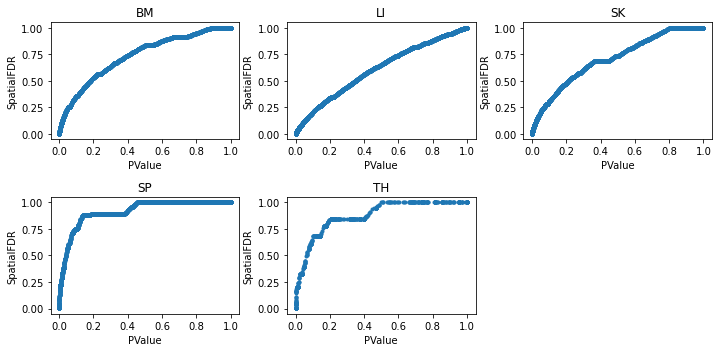

In [40]:
plt.rcParams["figure.figsize"] = [10,5]
i=1
for k in milo_res_2.keys():
    plt.subplot(2,3,i)
    plt.plot(milo_res_2[k].PValue, milo_res_2[k].SpatialFDR, '.');
    plt.title(k);
    plt.tight_layout();
    plt.xlabel("PValue");
    plt.ylabel("SpatialFDR");
    i+=1

In [41]:
## Exclude neighbourhoods where DA is explained by 10X protocol
# (eliminates false positives in the thymus, where there is partial
# confounding between method and age bins)
milo_res_method, org_fc_method, org_fdr_method = _milo_test_by_organ(adata, 
                                                      design="~ method",
                                                      test_organs = ["BM", "LI", "SK", "SP", "TH"]
                                                     )

org_fc_filtered_2 = org_fc_2.copy()
org_fdr_filtered_2 = org_fdr_2.copy()
for o in ["BM", "LI", "SK", "SP", "TH"]:
    org_fc_filtered_2["logFC_" + o][org_fdr_method["SpatialFDR_" + o] < 0.1] = np.nan
    org_fdr_filtered_2["SpatialFDR_" + o][org_fdr_method["SpatialFDR_" + o] < 0.1] = np.nan


BM


/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


LI
SK
SP
TH


### Visualize with beeswarm plot

In [42]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

In [43]:
org_fc_filtered = org_fc_filtered_2.copy()

## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

In [44]:
%%R -i org_fc_filtered -i org_fdr_2 -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr_2 %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ## Fix some names
    mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(organ, nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    group_by(nhood_anno) %>%
    filter(length(unique(Nhood)) > 20) %>%
    ungroup()

head(plot_df)

Joining, by = c("Nhood", "organ")
  Nhood         nhood_anno anno_group organ    logFC   SpatialFDR mean_logFC
1  7137 SPLENIC_MACROPHAGE    MYELOID    SP 2.355562 2.213517e-02   2.355562
2  7455       BM_CD14_MONO    MYELOID    BM 2.316697 1.963394e-06   2.316697
3  7126 SPLENIC_MACROPHAGE    MYELOID    SP 2.287337 2.305320e-02   2.287337
4  7434       BM_CD14_MONO    MYELOID    BM 2.230250 1.469900e-06   2.230250
5  7424       BM_CD14_MONO    MYELOID    BM 2.229790 7.881420e-07   2.229790
6  7427       BM_CD14_MONO    MYELOID    BM 2.175692 2.441959e-06   2.175692


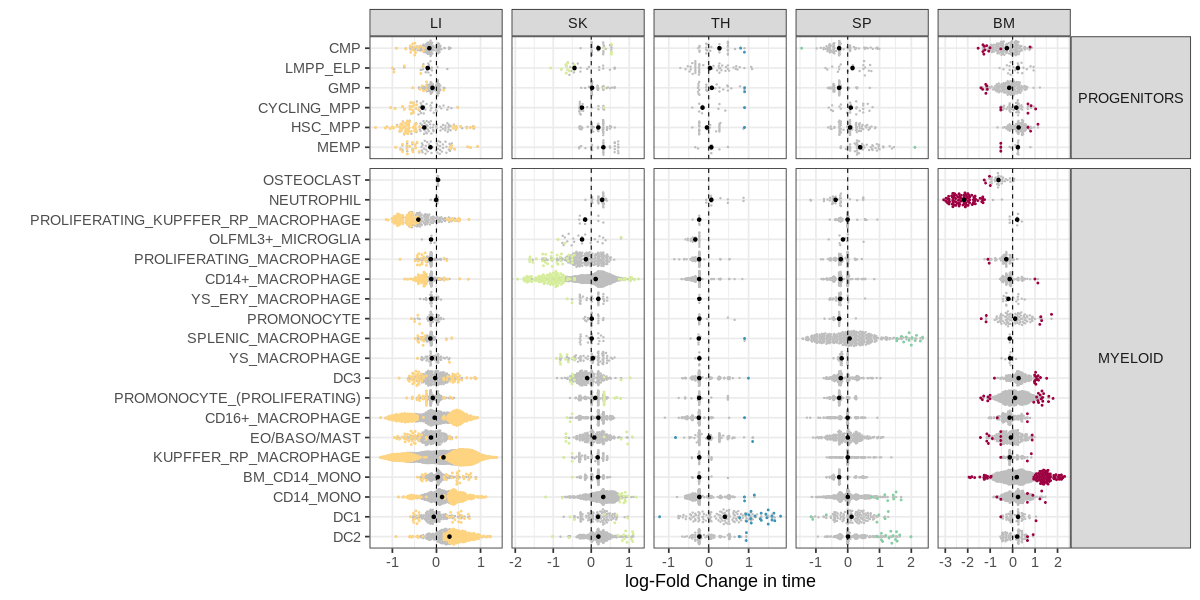

In [48]:
%%R -w 1200 -h 600 -i figdir -o pl_df
library(ggbeeswarm)
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

anno_group_order <- c("PROGENITORS", "ERYTHROID CELLS", "ILC", "MYELOID", "NK/T CELLS", "B CELLS")

pl_df <- plot_df %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(- mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% c("PROGENITORS", "MYELOID"))

alpha=0.1
set.seed(12345)
pl1 <- pl_df %>%
    mutate(organ_color=ifelse(SpatialFDR < alpha, as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
    geom_quasirandom(size=0.5, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.7, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))
    
pl1 
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

Visualize distribution in age

In [65]:
# org_count_df = anno_obs.groupby(["organ", "anno_lvl_2_final_clean"]).count()['is_annotated'].reset_index()
# anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
# org_count_df["anno_group"] = [anno_groups_dict_rev[x] if x in anno_groups_dict_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
# org_count_df.loc[org_count_df["anno_group"].isna(), "anno_group"] = "ERYTHROID CELLS"
# org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

In [60]:
org_colors = pd.read_csv("../../metadata/organ_colors.csv", index_col=0)

age_count_df = anno_obs.loc[adata.obs_names].groupby(["age", "anno_lvl_2_final_clean"]).count()['is_annotated'].reset_index()
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
age_count_df["anno_group"] = [anno_groups_dict_rev[x] if x in anno_groups_dict_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df.loc[age_count_df["anno_group"].isna(), "anno_group"] = "ERYTHROID CELLS"
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

In [62]:
%%R -i age_count_df --i figdir -w 800 -h 1000
anno_order <- unique(as.character(pl1$data$nhood_anno))

age_pl_df <- age_count_df %>%
    rename(N_cells = is_annotated) %>%
    group_by(anno) %>%
    mutate(anno=factor(anno, levels=anno_order)) %>%
    filter(!is.na(anno)) %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% c("PROGENITORS", "MYELOID"))
   
    
pl2 <- age_pl_df %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=age),position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_viridis_c() +
    theme_bw(base_size=14) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    expand_limits(y = 1.3) +
    geom_text(data=. %>% group_by(anno) %>% 
              summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
              hjust=0,
              y=1.01, aes(label=paste("N =", N_cells))
             ) 
#     ggsave(paste0(figdir, "age_distribution.pdf"), height=16, width=12) +
#     ggsave(paste0(figdir, "age_distribution.png"), height=16, width=12) 

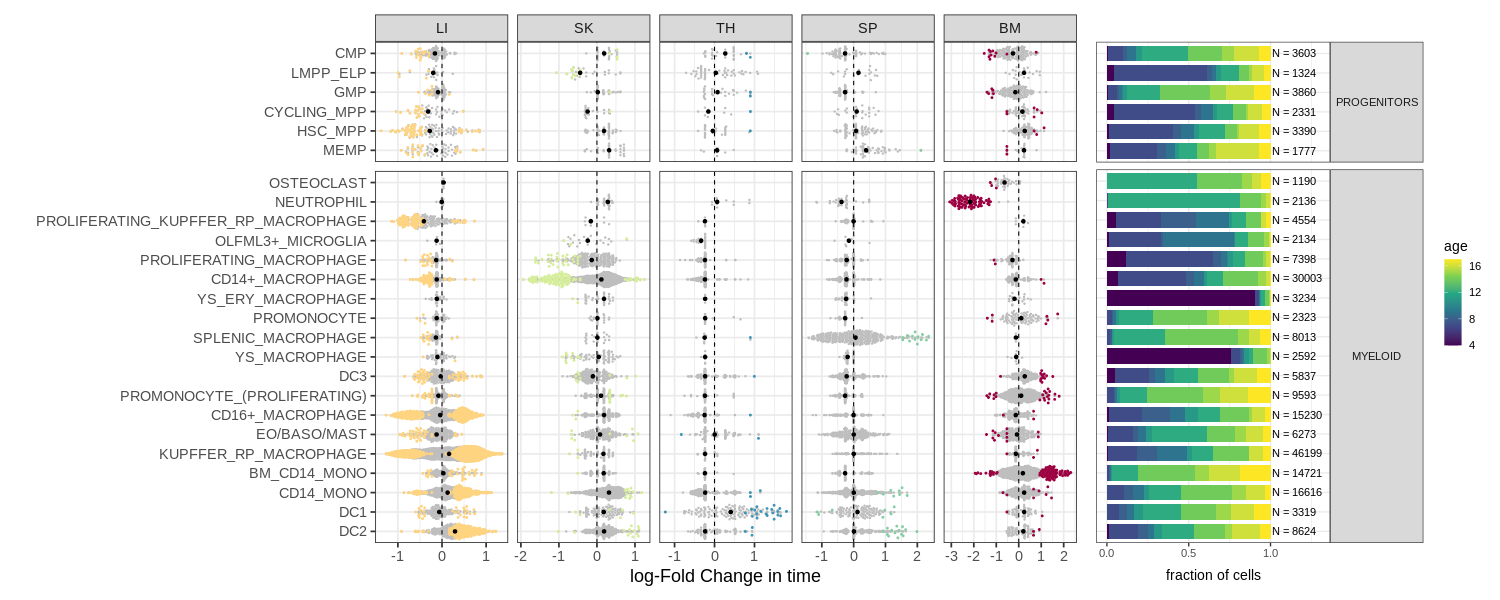

In [112]:
%%R -w 1500 -h 600
(pl1 + theme(strip.background.y=element_blank(), strip.text.y=element_blank())) +
(pl2 + remove_y_axis()) +
plot_layout(widths=c(3,1)) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=25, height=10) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=25, height=10)

### Visualize on UMAP

In [77]:
milopy.utils.build_nhood_graph(adata)

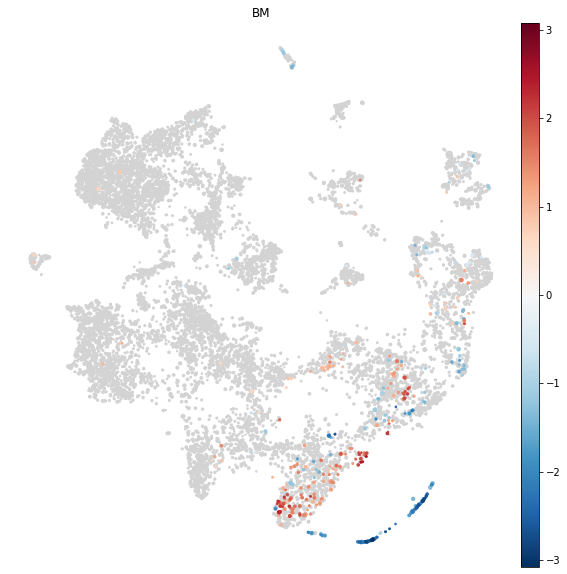

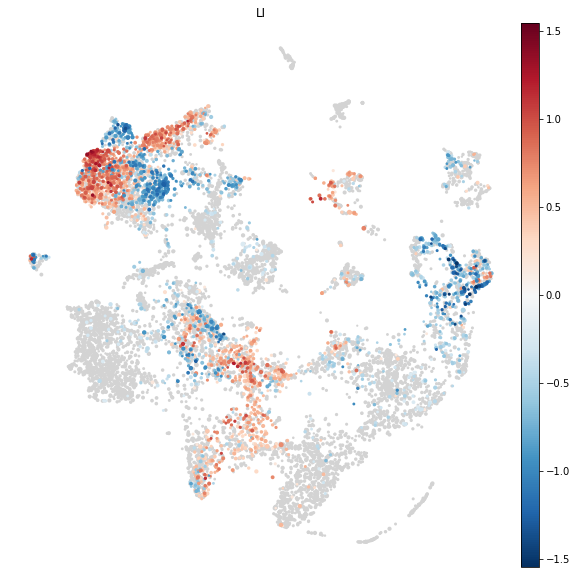

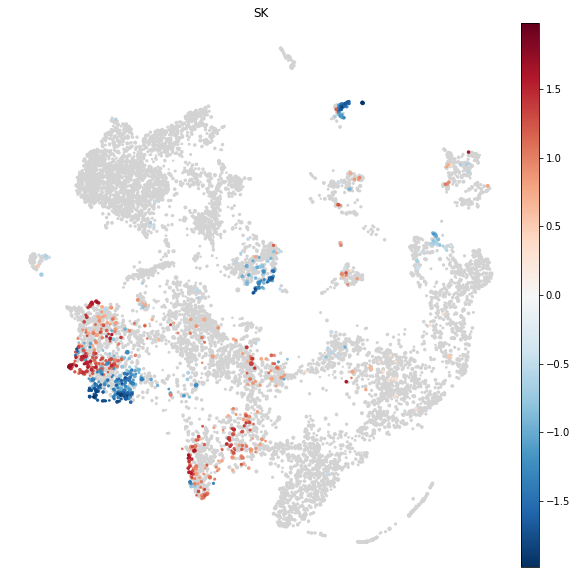

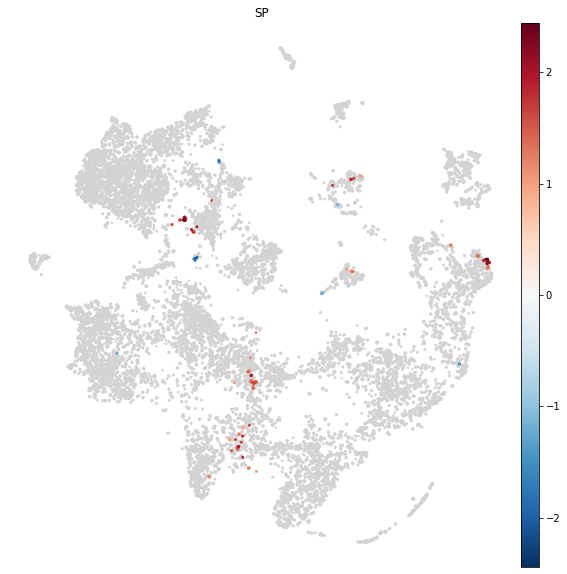

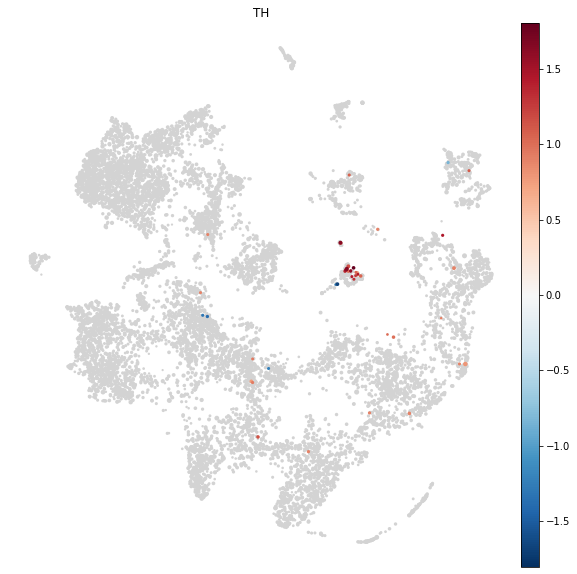

In [111]:
test_organs = ["BM", "LI", "SK", "SP", "TH"]
for i in range(len(test_organs)):
    adata.uns["nhood_adata"].obs = milo_res_2[test_organs[i]].copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopy.plot.plot_nhood_graph(adata, min_size=1, title=test_organs[i])


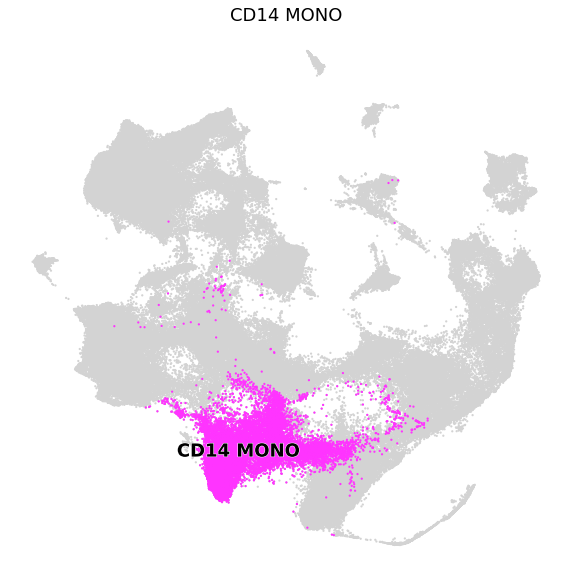

In [345]:
scv.pl.umap(adata, color="anno_lvl_2_final_clean", groups="CD14_MONO", size=20)

### Save processed outputs

In [102]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_outs/{s}/'.format(s=split)
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Save dataframe for beeswarm plot
pl_df.to_csv(outdir + "milo_beeswarm_plot_data.{s}.csv".format(s=split))

## Save processed anndata object
nhood_adata = adata.uns["nhood_adata"].copy()
adata.obs.drop("remarks", axis=1, inplace=True)
del adata.uns["nhood_adata"]
adata.write_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))
adata.uns["nhood_adata"] = nhood_adata.copy()

nhood_adata.uns["annotation_labels"] = nhood_adata.uns["annotation_labels"].tolist()
nhood_adata.write_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))

### Differential expression analysis

Calculate mean expression for each neighbourhood

In [105]:
## Add mean expression for each neighbourhood
nhood_adata = adata.uns["nhood_adata"].copy()
X = adata.X
expr_id = "expr" 
## Aggregate over nhoods -- taking the mean
nhoods_X = X.T.dot(adata.obsm["nhoods"])

from scipy.sparse import csr_matrix
nhoods_X = csr_matrix(nhoods_X / adata.obsm["nhoods"].toarray().sum(0))
adata.uns["nhood_adata"].obsm[expr_id] = nhoods_X.T

Label neighbourhoods by outcome in each organ test

In [65]:
long_org_fc = pl_df.copy()
alpha=0.1

In [172]:
signif_early = (long_org_fc['SpatialFDR'] < alpha) & (long_org_fc['logFC'] < 0)
signif_late = (long_org_fc['SpatialFDR'] < alpha) & (long_org_fc['logFC'] > 0)
not_signif = (long_org_fc['SpatialFDR'] >= alpha)

long_org_fc['test_label'] = "not_signif"
long_org_fc.loc[signif_late, "test_label"] = "signif_late"
long_org_fc.loc[signif_early, "test_label"] = "signif_early"

In [548]:
def test_DGE(adata, long_org_fc, subset_organ, subset_anno, alpha=0.1, condition='signif_late'):
    '''
    Extract cells in neighbourhoods with significant enrichment in early or late cells and use 
    simple scanpy test to find markers VS the rest of cells in the same organ/annotation.
    
    Params:
    -------
    - long_org_fc: long format dataframe containing milo testing results
    - subset_organ: list of organs to test in
    - subset_anno: list or cell types to test in (values or `anno_lvl_2_final_clean`)
    - alpha: significance FDR threshold (default=0.1)
    - condition: which condition to compare to the rest? (either `signif_late` or `signif_early`)

    '''
    keep_nhoods_df = long_org_fc[(long_org_fc.organ.isin(subset_organ)) & (long_org_fc.nhood_anno.isin(subset_anno))][["Nhood", "test_label"]]
    pick_nhoods = keep_nhoods_df[keep_nhoods_df['test_label'] == condition]["Nhood"].astype('int')

    cells_in_nhoods = adata.obsm["nhoods"][:,pick_nhoods].toarray().sum(1) > 0
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))

    test_adata = adata[cells_in_org]

    case_cells = adata[cells_in_org & cells_in_nhoods].obs_names
    test_adata.obs["test_condition"] = 'control'
    test_adata.obs.loc[case_cells, "test_condition"] = 'case'
#     if len(case_cells) < 10:
    sc.tl.rank_genes_groups(test_adata, groupby="test_condition", groups=["case"])
    
    ## Get dataframe of results
    dge_dict = test_adata.uns['rank_genes_groups'].copy()
    dge_dict.pop("params")
    dge_dict = {k:[x[0] for x in dge_dict[k]] for k,v in dge_dict.items()}
    dge_df = pd.DataFrame.from_dict(dge_dict)
    
    return(test_adata, dge_df)

def plot_DGE(test_adata, dge_df, subset_organ, subset_anno, n_genes=30, figsize=[4,10], save=False):
    ## Extract top genes and order by FC
    genes_df = dge_df.sort_values("pvals_adj").iloc[0:n_genes]
    genes = genes_df.sort_values("logfoldchanges", ascending=False)["names"]

    test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
    pl_title = ''.join(subset_anno) + " - " + ''.join(subset_organ) 
    ax = sc.pl.dotplot(test_adata, genes, groupby='age_bins', dendrogram=False, cmap="Reds", 
    #                      standard_scale="var"
                         return_fig=False, title=pl_title, swap_axes=True, show=False, 
                               figsize=figsize 
                        );
    fig = plt.gcf()
    plot_ax = fig.axes[1]
    cbar_ax = fig.axes[-1]
    cbar_ax.set_title("Median\nexpression");
    bins_labels = dict(zip([str(x) for x in range(len(cut_labels_4))], cut_labels_4))
    plot_ax.set_xticklabels([bins_labels[x.get_text()] for x in plot_ax.get_xticklabels()], 
                            rotation=45, ha="right");
    if save:
        fig.savefig(figdir + pl_title + '_stacked_violin.png', bbox_inches="tight")

Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical


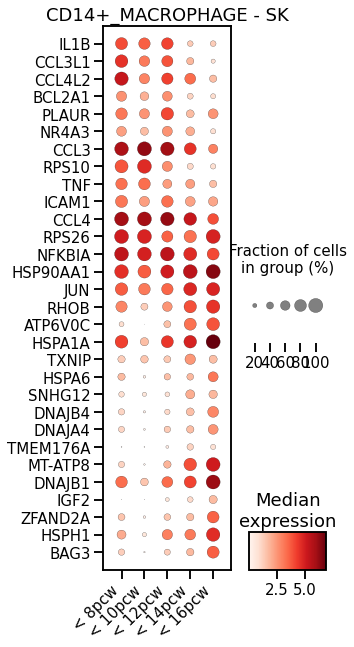

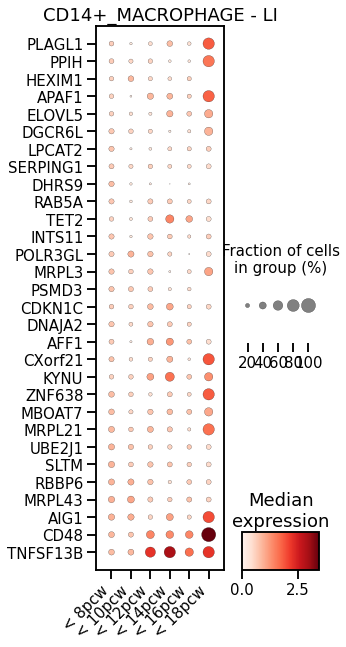

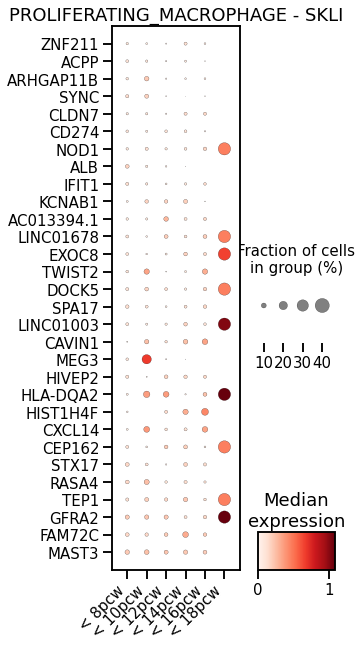

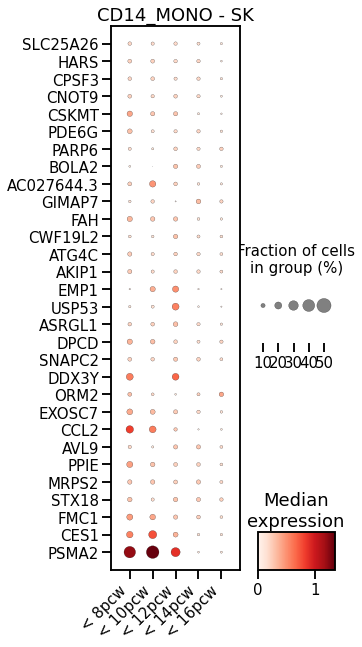

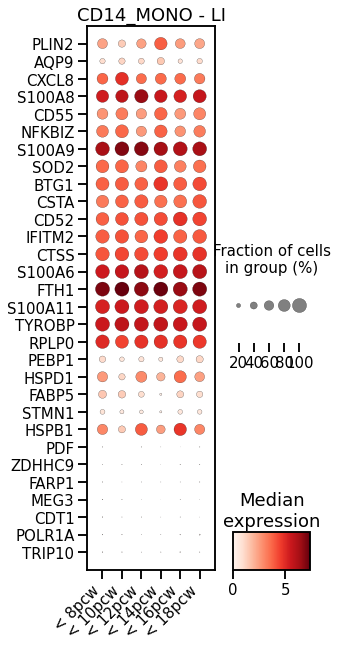

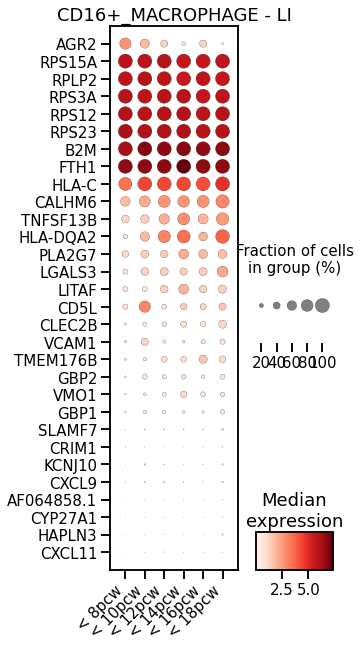

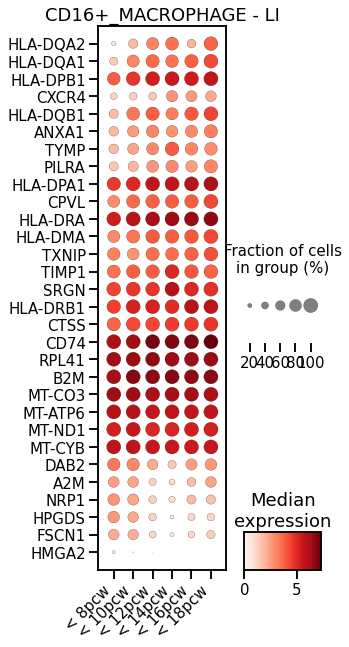

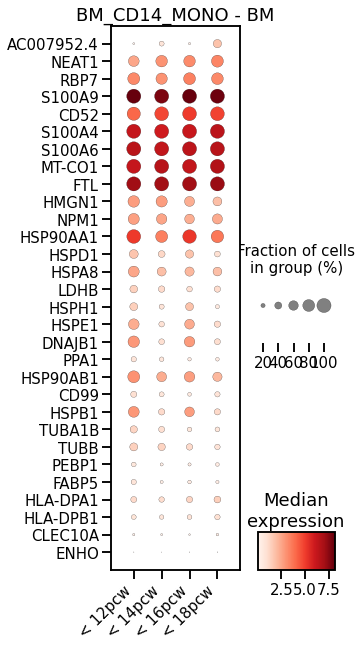

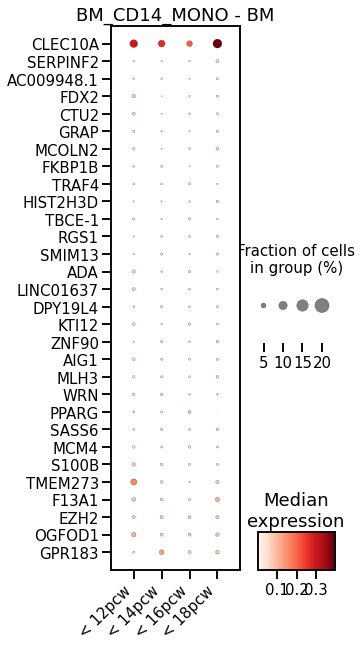

In [549]:
query_sets = [
    (["CD14+_MACROPHAGE"],["SK"], "signif_early"), 
    (["CD14+_MACROPHAGE"],["LI"], "signif_early"), 
    (["PROLIFERATING_MACROPHAGE"],["SK", "LI"], "signif_early"), 
    (["CD14_MONO"],["SK"], "signif_late"), 
    (["CD14_MONO"],["LI"], "signif_late"),
    (["CD16+_MACROPHAGE"],["LI"], "signif_early"),
    (["CD16+_MACROPHAGE"],["LI"], "signif_late"),
    (["BM_CD14_MONO"],["BM"], "signif_late"),
    (["BM_CD14_MONO"],["BM"], "signif_early"),
]

dge_results = []
for subset_anno, subset_organ, condition in query_sets:
    test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition)
    plot_DGE(test_adata, dge_df, subset_organ, subset_anno, save=True)
    dge_results.append([subset_anno, subset_organ, condition, test_adata, dge_df])

In [552]:
import pickle
with open(data_dir + 'tmp/DGE_milo_MYELOID.pickle', 'wb') as fout:
    pickle.dump(dge_results, fout)

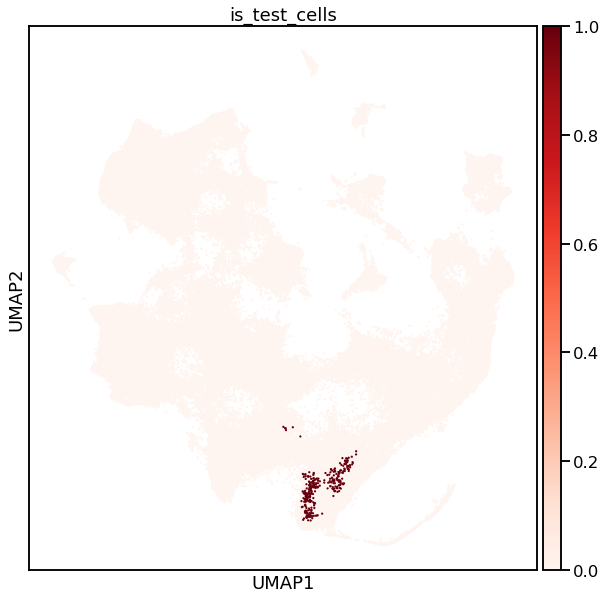

In [554]:
test_cells = test_adata.obs_names[test_adata.obs.test_condition=="case"]
adata.obs["is_test_cells"] = adata.obs_names.isin(test_cells).astype("int")

sc.pl.umap(adata, color=["is_test_cells"], size=20, cmap="Reds")

---
---

### Junk n snippets

In [233]:
import rpy2.robjects.pandas2ri
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import STAP

def _test_lognormal_dge_limma(test_adata, model_contrasts="test_labelsignif_early-test_labelsignif_late"):
    r_fct_string = '''
    library(limma)
    perform_lognormal_dge <- function(exprs.data, 
                                      covariate, 
                                      design = "~0+test_label",
                                      gene.offset=TRUE,
                                      model_contrasts=NULL, 
                                      n.coef=NULL){

        test.model = model.matrix(as.formula(design), data=as.data.frame(covariate))

        if(isTRUE(gene.offset)){
            n.gene <- apply(exprs.data, 2, function(X) sum(X > 0))
            old.col <- colnames(test.model)
            if(all(test.model[, 1] == 1)){
                test.model <- cbind(test.model[, 1], n.gene, test.model[, c(2:ncol(test.model))])
                colnames(test.model) <- c(old.col[1], "NGenes", old.col[c(2:length(old.col))])
            } else{
                test.model <- cbind(n.gene, test.model)
                colnames(test.model) <- c("NGenes", old.col)
            }
        }

        i.fit <- lmFit(exprs.data, test.model)
        if(!is.null(model_contrasts)){
            mod.constrast <- makeContrasts(contrasts=model_contrasts, levels=test.model)
            i.fit <- contrasts.fit(i.fit, contrasts=mod.constrast)
            i.fit <- eBayes(i.fit, trend=TRUE)
            i.res <- as.data.frame(topTreat(i.fit, number = Inf, sort.by = "p", p.value = 1))
        } else{
            i.fit <- eBayes(i.fit, trend=TRUE)
            if(is.null(n.coef)){
                n.coef <- ncol(test.model)
            }

            i.res <- as.data.frame(topTreat(i.fit, coef=ncol(test.model), number = Inf, sort.by = "none", p.value = 1))
        }
        return(data.frame(i.res))
    }
    '''

    r_pkg = STAP(r_fct_string, "r_pkg")

    expr = test_adata.X.toarray()
    covariate = test_adata.obs[["test_label"]]
    gene_names = test_adata.var_names

    # CONVERT PYTHON NUMPY MATRICES TO R OBJECTS
    r_X = map(rpy2.robjects.numpy2ri, expr)
    r_cov = map(rpy2.robjects.pandas2ri, covariate)

    # PASS R OBJECTS INTO FUNCTION (WILL NEED TO EXTRACT DFs FROM RESULT)
    p_res = r_pkg.perform_lognormal_dge(expr.T, covariate, model_contrasts=model_contrasts)

    results = pd.DataFrame(p_res)
    results.index = gene_names

    return(results.sort_values("adj.P.Val"))

def label_early_and_late_nhoods(long_org_fc, subset_anno, 
                                subset_organ=None,
                                fc_cutoff = 0
                               ):
    if subset_organ is not None:
        keep_nhoods = long_org_fc['nhood_anno'].isin(subset_anno) & long_org_fc['organ'].isin(subset_organ)
    else:
        keep_nhoods = long_org_fc['nhood_anno'].isin(subset_anno)
    ## Take mean fold change across organs
    mean_fc = long_org_fc[keep_nhoods].groupby('Nhood').mean()["logFC"]

    ## Split based on fold-change cutoff
    late_nhoods = mean_fc > fc_cutoff
    early_nhoods = mean_fc < - fc_cutoff
    
    late_ixs = mean_fc.index[late_nhoods]
    early_ixs = mean_fc.index[early_nhoods]

    return(late_ixs, early_ixs, mean_fc)
    

In [234]:
def run_early_late_dge(long_org_fc, 
                       subset_anno,
                       subset_organ=None,
                       min_lfc=0.25,
                       min_n_nhoods=50):

    late,early,_ = label_early_and_late_nhoods(long_org_fc, subset_anno=subset_anno, subset_organ=subset_organ)
    nhood_adata = adata.uns["nhood_adata"].copy()
    anno_nhood_adata = nhood_adata[nhood_adata.obs["nhood_annotation"].isin(subset_anno)]

    test_label = ["early" if int(x) in (early -1 ) else "late" if int(x) in (late - 1) else np.nan for x in anno_nhood_adata.obs_names]
    anno_nhood_adata.obs["test_label"] = pd.Series(test_label).astype("category").values

    X_mat = anno_nhood_adata.obsm["expr"]
    test_adata = anndata.AnnData(X=X_mat, obs=anno_nhood_adata.obs, var=adata.var)
    test_adata = test_adata[~test_adata.obs["test_label"].isna()]

    ## Test differential expression
    dge_limma_df = _test_lognormal_dge_limma(test_adata)

    ## Extract top genes
    top_dge = dge_limma_df[(dge_limma_df['logFC'].abs() > min_lfc) & (dge_limma_df["adj.P.Val"] < 0.01)]

    top_early = top_dge[top_dge.logFC < 0].index
    top_late = top_dge[top_dge.logFC > 0].index
    
    params = {'subset_anno':subset_anno, "subset_organ":subset_organ, "min_lfc":min_lfc, 'min_n_nhoods':min_n_nhoods}
    return(top_early, top_late, params)

Test for DGE in interesting cell types

In [ ]:
import json

query_sets = [
    (["CD14+_MACROPHAGE"],["SK", "LI"]), 
    (["ILC3"],None), 
    (["HSC_MPP"], ["LI"]), 
    (["CD4+T", 'CD8+T'], ["TH"]),
    (['TREG'], ["TH"]),
    (['ABT(ENTRY)'], ["TH"]),
    (["DP(Q) T CELL", 'DP(P) T CELL'], ["TH"]),
    (["DN(Q) T CELL", 'DN(P)_DN(EARLY) T CELL'], ["TH"]),
    (["LATE_ERYTHROID", "MID_ERYTHROID", "EARLY_ERYTHROID"], ["LI"])
]

dge_results = []
for anno,org in query_sets:
    print(anno)
    early,late,params = run_early_late_dge(long_org_fc, anno, subset_organ=org, min_lfc=0.5)
    params["early_genes"] = early
    params["late_genes"] = late
    dge_results.append(params)

## Save to json
for i in range(len(dge_results)):
    dge_results[i]["early_genes"] = dge_results[i]["early_genes"].tolist()
    dge_results[i]["late_genes"] = dge_results[i]["late_genes"].tolist()
with open(data_dir + 'tmp/DGE_early_late_nhoods.json', 'w') as fout:
    json.dump(dge_results, fout)

['NK']


Trying to set attribute `.obs` of view, copying.


['ILC3']


Trying to set attribute `.obs` of view, copying.


In [ ]:
## Extract top genes
top_dge = dge_limma_df[(dge_limma_df['logFC'].abs() > min_lfc) & (dge_limma_df["adj.P.Val"] < 0.01)]

top_early = top_dge[top_dge.logFC < 0].index
top_late = top_dge[top_dge.logFC > 0].index

params = {'subset_anno':subset_anno, "subset_organ":subset_organ, "min_lfc":min_lfc, 'min_n_nhoods':min_n_nhoods}
return(top_early, top_late, params)